## Imports and Data Loading

In [1]:
# Imports
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import umap.umap_ as umap

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import Dataset

In [2]:
# Load parquet files
ROOT = './'
feats = pd.read_parquet(ROOT + 'data/features.parquet')
lcs = pd.read_parquet(ROOT + 'data/lcs.parquet')
oids = pd.read_parquet(ROOT + 'data/oids.parquet')

## Datasets

In [3]:
# Merge features and oids on 'oid' to create a simple dataset
dataset = pd.merge(oids, feats, on='oid', how='inner')

In [4]:
# Define a simple PyTorch Dataset with the same logic of above
class SimpleFeatureDataset(Dataset):
    def __init__(self, data_path):
        feats = pd.read_parquet(f'{data_path}/features.parquet')
        oids = pd.read_parquet(f'{data_path}/oids.parquet')
        # Merge features and oids on 'oid' (you can select the features you want)
        merged = pd.merge(oids, feats, on='oid', how='inner')
        # Replace NaN with -99 (you can improve this with other strategies)
        self.data = merged.fillna(-99)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data.iloc[idx] # You can convert to tensor if needed

torch_dataset = SimpleFeatureDataset('./data')

## EDA and Visualization

### Shows data and describe

In [ ]:
# Print shapes of the loaded data
print(f"Features shape: {feats.shape}")
print(f"Lightcurves shape: {lcs.shape}")
print(f"OIDs shape: {oids.shape}")

print("\n---")

# Show basic info of dataset
print("\nDataset info:")
print(f"Rows: {len(dataset)}, Columns: {len(dataset.columns)}")
# First columns
print(dataset.columns[:5])

print("\n---")

# Show basic info PyTorch dataset
print("\nPyTorch Dataset info:")
print(f"PyTorch Dataset length: {len(torch_dataset)}")
# Example usage
print(torch_dataset[0])

Features shape: (8419, 179)
Lightcurves shape: (5189550, 31)
OIDs shape: (9829, 2)

---

Dataset info:
Rows: 8419, Columns: 180
Index(['oid', 'alerceclass', 'Q31_r', 'Rcs_r', 'Skew_r'], dtype='object')

---

PyTorch Dataset info:
PyTorch Dataset length: 8419
oid                               ZTF18abmrdyx
alerceclass                                CEP
Q31_r                                    -99.0
Rcs_r                                    -99.0
Skew_r                                   -99.0
SmallKurtosis_r                          -99.0
Std_r                                    -99.0
StetsonK_r                               -99.0
Pvar_r                                   -99.0
ExcessVar_r                              -99.0
PairSlopeTrend_r                         -99.0
SF_ML_amplitude_r                        -99.0
SF_ML_gamma_r                            -99.0
IAR_phi_r                                -99.0
LinearTrend_r                            -99.0
delta_mag_fid_g                     

In [6]:
feats.head()

,oid,Q31_r,Rcs_r,Skew_r,SmallKurtosis_r,Std_r,StetsonK_r,Pvar_r,ExcessVar_r,PairSlopeTrend_r,...,max_diffmaglim_after_fid_g,median_diffmaglim_after_fid_g,delta_mag_fid_r,delta_mjd_fid_r,first_mag_r,mean_mag_r,min_mag_r,n_det_r,PercentAmplitude_r,Harmonics_mag_5_r
0,ZTF18abmrdyx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.6052,20.102501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ZTF18abdvyys,0.657821,0.184957,-0.453637,-1.119874,0.347335,0.912642,1.0,0.000661,0.033333,...,20.2962,19.485350,1.063133,1362.247535,13.470280,13.492689,12.974045,22.0,0.048942,0.114427
2,ZTF18abjgfrd,0.241344,0.204626,0.171970,-1.878280,0.119813,0.960020,1.0,0.000053,-0.033333,...,NaN,NaN,0.309963,1362.159144,16.484390,16.323530,16.177994,37.0,0.015189,0.236205
3,ZTF20aaksrbb,0.063570,0.436321,0.481466,-0.290408,0.042348,0.849919,1.0,0.000008,0.100000,...,21.0254,20.326300,0.117467,614.180752,14.485116,14.481151,14.436781,10.0,0.005410,260.767868
4,ZTF18abwqcoy,0.090321,0.237630,1.273315,0.891479,0.341080,0.738760,1.0,0.000303,0.066667,...,21.2738,20.220000,0.893099,797.913345,19.131857,19.246591,19.026735,13.0,0.044680,448.948945


In [7]:
feats.describe()

,Q31_r,Rcs_r,Skew_r,SmallKurtosis_r,Std_r,StetsonK_r,Pvar_r,ExcessVar_r,PairSlopeTrend_r,SF_ML_amplitude_r,...,max_diffmaglim_after_fid_g,median_diffmaglim_after_fid_g,delta_mag_fid_r,delta_mjd_fid_r,first_mag_r,mean_mag_r,min_mag_r,n_det_r,PercentAmplitude_r,Harmonics_mag_5_r
count,7694.000000,7694.000000,7694.000000,7694.000000,7694.000000,7694.000000,7.694000e+03,7694.000000,7694.000000,7694.000000,...,8045.000000,8045.000000,7885.000000,7885.000000,7885.000000,7885.000000,7885.000000,7885.000000,7694.000000,7.885000e+03
mean,0.386163,0.168959,0.047430,0.281581,0.253389,0.814502,9.930798e-01,0.000478,0.004861,0.628818,...,21.190174,20.091485,0.926920,1243.084857,15.423586,15.427888,14.980499,175.867977,0.043515,3.447564e+08
std,0.381601,0.088045,1.052078,4.342269,0.225771,0.112081,7.149802e-02,0.001293,0.140073,1.415894,...,1.257391,0.297043,0.907358,285.026655,1.750585,1.728515,1.779271,161.380534,0.040508,2.735986e+10
min,0.012007,0.033547,-5.128562,-2.056041,0.011614,0.300194,1.785700e-08,-0.000658,-0.833333,-0.500000,...,17.660100,17.645201,0.000000,0.000000,9.794477,11.515887,9.330558,1.000000,0.001334,0.000000e+00
25%,0.171985,0.101212,-0.588088,-1.445527,0.143662,0.743824,1.000000e+00,0.000082,-0.100000,0.210892,...,20.903000,19.957800,0.468344,1184.955764,14.034469,14.048332,13.603972,56.000000,0.022414,1.393093e-02
50%,0.327993,0.145209,-0.044641,-0.870908,0.195420,0.835062,1.000000e+00,0.000158,0.033333,0.297018,...,21.036800,20.151350,0.685512,1346.190937,15.393001,15.361316,14.946087,127.000000,0.031204,3.348942e-02
75%,0.456659,0.219382,0.575249,0.384304,0.277768,0.904644,1.000000e+00,0.000314,0.100000,0.426420,...,21.145100,20.287800,0.998816,1428.123738,16.722733,16.728360,16.331780,252.000000,0.047550,1.492112e-01
max,4.230939,0.495398,9.521461,114.907867,2.211755,0.995508,1.000000e+00,0.019245,0.900000,15.000000,...,59.890701,20.830099,7.916711,1484.118032,21.504791,21.245582,20.548330,1292.000000,0.311038,2.420808e+12


In [8]:
lcs.head()

,oid,tid,mjd,candid,fid,pid,diffmaglim,isdiffpos,nid,distnr,...,drb,magapbig,sigmagapbig,rfid,has_stamp,corrected,dubious,step_id_corr,phase,parent_candid
0,ZTF18aaasdsx,ztf,58534.325521,780325525915010000,2,780325525915,19.043385,-1,780,0.610149,...,0.000000,17.6957,0.1103,1.706120e+09,False,True,False,bulk_1.0.0,0.0,7.862174e+17
1,ZTF18aaasdsx,ztf,58540.217419,786217415915010005,2,786217415915,20.599041,-1,786,0.096748,...,0.000000,18.3134,0.0638,1.706120e+09,True,True,False,bulk_1.0.0,0.0,0.000000e+00
2,ZTF18aaasdsx,ztf,58585.142894,831142895915010001,2,831142895915,19.849493,-1,831,0.081787,...,0.000000,17.8272,0.0752,1.706120e+09,True,True,False,bulk_1.0.0,0.0,0.000000e+00
3,ZTF18aaasdsx,ztf,60539.508808,2785508805915015004,2,2785508805915,18.699131,1,2785,0.642389,...,0.998189,18.1633,0.2563,1.706120e+09,True,True,False,24.5.1,0.0,NaN
4,ZTF18aaasdsx,ztf,60539.509282,2785509285915015003,2,2785509285915,18.652796,1,2785,0.036393,...,0.999355,18.4842,0.3564,1.706120e+09,True,True,False,24.5.1,0.0,NaN


In [9]:
lcs.describe()

,mjd,fid,pid,diffmaglim,isdiffpos,nid,distnr,magpsf,magpsf_corr,magap,...,sigmagap,ra,dec,rb,drb,magapbig,sigmagapbig,rfid,phase,parent_candid
count,5.189550e+06,5.189550e+06,5.189550e+06,5.189550e+06,5.189550e+06,5.189550e+06,5.189550e+06,5.189550e+06,5.154222e+06,5.189550e+06,...,5.189550e+06,5.189550e+06,5.189550e+06,5.189550e+06,3.770253e+06,5.189550e+06,5.189550e+06,3.770253e+06,5189550.0,3.080523e+06
mean,5.936161e+04,1.509215e+00,1.607609e+12,2.008599e+01,-2.713800e-02,1.607286e+03,3.285736e-01,1.726877e+01,1.594597e+01,1.733418e+01,...,7.268280e-02,2.426517e+02,3.737143e+01,7.224959e-01,7.802667e-01,1.731699e+01,8.950740e-02,7.242104e+08,0.0,1.272850e+18
std,6.393632e+02,4.999151e-01,6.393632e+11,6.032817e-01,9.996318e-01,6.393554e+02,2.965118e-01,1.582898e+00,4.383700e+00,1.577486e+00,...,8.779667e-02,1.100680e+02,2.290572e+01,1.750215e-01,3.700571e-01,1.580607e+00,1.105420e-01,6.246142e+09,0.0,5.781291e+17
min,5.824215e+04,1.000000e+00,4.881528e+11,1.032000e+01,-1.000000e+00,4.880000e+02,1.675851e-04,8.220855e+00,9.330558e+00,8.319900e+00,...,5.000000e-04,4.003930e-02,-2.923914e+01,1.285714e-02,0.000000e+00,8.308500e+00,5.000000e-04,2.281201e+08,0.0,0.000000e+00
25%,5.878515e+04,1.000000e+00,1.031149e+12,1.973466e+01,-1.000000e+00,1.031000e+03,1.459190e-01,1.613180e+01,1.446807e+01,1.621130e+01,...,1.610000e-02,2.118162e+02,2.227029e+01,6.071429e-01,7.611415e-01,1.619060e+01,1.810000e-02,5.911203e+08,0.0,9.344296e+17
50%,5.929843e+04,2.000000e+00,1.544433e+12,2.018914e+01,-1.000000e+00,1.544000e+03,2.547770e-01,1.736795e+01,1.576598e+01,1.743210e+01,...,3.910000e-02,2.885772e+02,4.161094e+01,7.542857e-01,9.948432e-01,1.741650e+01,4.650000e-02,7.251202e+08,0.0,1.131454e+18
75%,5.987643e+04,2.000000e+00,2.122434e+12,2.053769e+01,1.000000e+00,2.122000e+03,4.279019e-01,1.850521e+01,1.697913e+01,1.855590e+01,...,9.650000e-02,3.185974e+02,5.576089e+01,8.685714e-01,9.999519e-01,1.854060e+01,1.190000e-01,8.011202e+08,0.0,1.430280e+18
max,6.054451e+04,2.000000e+00,2.790506e+12,2.169945e+01,1.000000e+00,2.790000e+03,1.456330e+01,2.145476e+01,1.000000e+02,2.215920e+01,...,1.473300e+00,3.599351e+02,8.610620e+01,9.914290e-01,1.000000e+00,2.219010e+01,1.786500e+00,1.001872e+12,0.0,2.790501e+18


In [10]:
oids.head()

,oid,alerceclass
index,,
34266,ZTF18abmrdyx,CEP
24912,ZTF18abdvyys,CEP
16221,ZTF18abjgfrd,CEP
26781,ZTF18aaasdsx,CEP
12086,ZTF20aaksrbb,CEP


In [11]:
oids.describe()

,oid,alerceclass
count,9829,9829
unique,9829,5
top,ZTF18abmrdyx,EB
freq,1,3000


In [12]:
# General statistics of the dataset
print(f"Statictics with describe: \n {dataset.describe()}")

Statictics with describe: 
              Q31_r        Rcs_r       Skew_r  SmallKurtosis_r        Std_r  \
count  7694.000000  7694.000000  7694.000000      7694.000000  7694.000000   
mean      0.386163     0.168959     0.047430         0.281581     0.253389   
std       0.381601     0.088045     1.052078         4.342269     0.225771   
min       0.012007     0.033547    -5.128562        -2.056041     0.011614   
25%       0.171985     0.101212    -0.588088        -1.445527     0.143662   
50%       0.327993     0.145209    -0.044641        -0.870908     0.195420   
75%       0.456659     0.219382     0.575249         0.384304     0.277768   
max       4.230939     0.495398     9.521461       114.907867     2.211755   

        StetsonK_r        Pvar_r  ExcessVar_r  PairSlopeTrend_r  \
count  7694.000000  7.694000e+03  7694.000000       7694.000000   
mean      0.814502  9.930798e-01     0.000478          0.004861   
std       0.112081  7.149802e-02     0.001293          0.140073   
m

### Null values and types

In [13]:
print(f"Null values count in the dataset: {dataset.isna().sum().sum()}")

Null values count in the dataset: 131480


In [14]:
print(f"Columns with nulls: {dataset.isna().any().sum()}")

Columns with nulls: 166


In [15]:
pd.set_option("display.max_rows", None) # Show all rows

# Columns with nulls and their counts
null_counts = (
    dataset.isna().sum()
    .reset_index()
    .rename(columns={"index": "column", 0: "nulls"})
    .query("nulls > 0")
    .sort_values(by="nulls", ascending=False)
)

print(f"Columns with nulls and their counts \n {null_counts}")

Columns with nulls and their counts 
                              column  nulls
168            dmag_first_det_fid_g   3500
165    last_diffmaglim_before_fid_g   3500
166           last_mjd_before_fid_g   3500
163     max_diffmaglim_before_fid_g   3500
164  median_diffmaglim_before_fid_g   3500
167              dmag_non_det_fid_g   3500
87     last_diffmaglim_before_fid_r   2893
90             dmag_first_det_fid_r   2893
85      max_diffmaglim_before_fid_r   2893
88            last_mjd_before_fid_r   2893
89               dmag_non_det_fid_r   2893
86   median_diffmaglim_before_fid_r   2893
114                            r-W3   1862
113                            r-W2   1857
112                            g-W3   1743
111                            g-W2   1739
110                           W2-W3   1415
109                           W1-W2   1410
51                 g-r_max_corr_g_r   1064
52                g-r_mean_corr_g_r   1064
59                     MHPS_ratio_r   1018
61              

### Alerceclass distribution

In [39]:
# Analysis of class distribution (alerceclass)
conteo_clase = dataset['alerceclass'].value_counts()

print("Distribution of classes:")
print(conteo_clase)

print("\n---")

print(f"\nNumber of unique classes: {dataset['alerceclass'].nunique()}")

print("\n---")

# Percentage per class
porcentaje_clase = (conteo_clase / len(dataset)) * 100

print("\nPercentage per class:")
print(porcentaje_clase)

Distribution of classes:
alerceclass
EB      2689
RRL     2652
LPV     1374
CEP     1172
DSCT     532
Name: count, dtype: int64

---

Number of unique classes: 5

---

Percentage per class:
alerceclass
EB      31.939660
RRL     31.500178
LPV     16.320228
CEP     13.920893
DSCT     6.319040
Name: count, dtype: float64


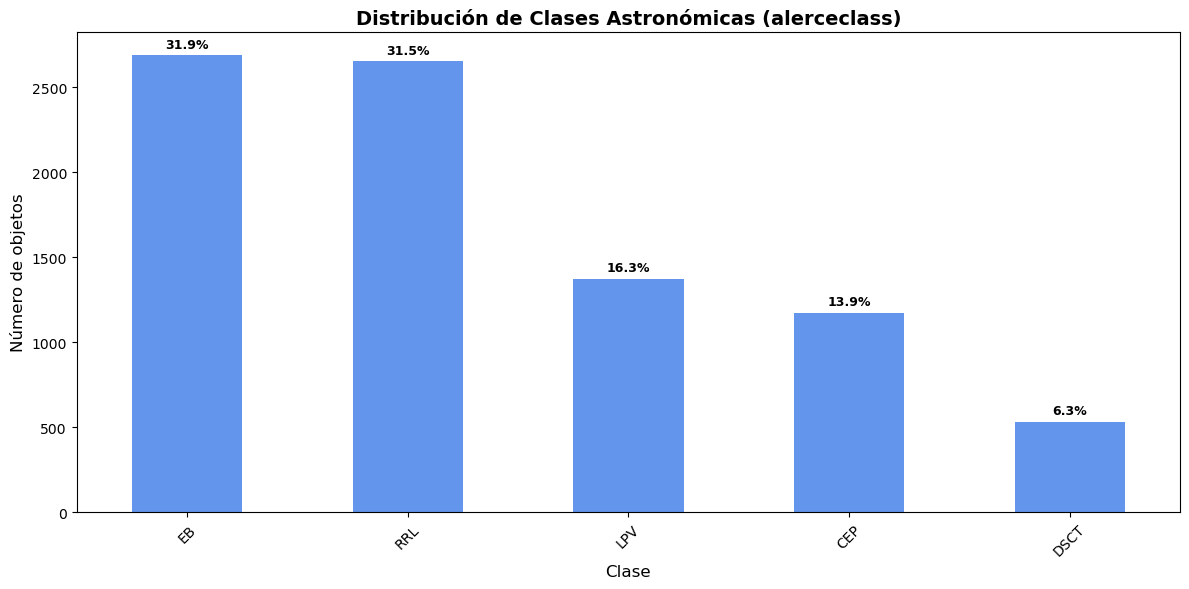

In [33]:
# Visualization - Only the bar chart
plt.figure(figsize=(12, 6))
bars = conteo_clase.plot(kind='bar', color='cornflowerblue')
plt.title('Distribución de Clases Astronómicas (alerceclass)', fontsize=14, fontweight='bold')
plt.xlabel('Clase', fontsize=12)
plt.ylabel('Número de objetos', fontsize=12)
plt.xticks(rotation=45)

# Add percentages on the bars
for i, v in enumerate(conteo_clase):
    porcentaje = porcentaje_clase.iloc[i]
    plt.text(i, v + max(conteo_clase)*0.01, f'{porcentaje:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
plt.tight_layout()
plt.show()

### Features distribution

In [40]:
# Identify numeric columns
numeric_cols = dataset.select_dtypes(include=[np.number]).columns.tolist()

print(f"Numeric features identified: {len(numeric_cols)}")

print("\n---")

print(f"\nName of the 10 first features: {numeric_cols[:10]}")

print("\n---")

desc_stats = dataset[numeric_cols].describe()

# Identify features with high variability
cv = desc_stats.loc['std'] / desc_stats.loc['mean']
high_var_features = cv.sort_values(ascending=False).head(10)
print("\nTop 10 features with greater variability coeficient:")
print(high_var_features)

Numeric features identified: 178

---

Name of the 10 first features: ['Q31_r', 'Rcs_r', 'Skew_r', 'SmallKurtosis_r', 'Std_r', 'StetsonK_r', 'Pvar_r', 'ExcessVar_r', 'PairSlopeTrend_r', 'SF_ML_amplitude_r']

---

Top 10 features with greater variability coeficient:
SmallKurtosis_g      303.156234
GP_DRW_tau_g          87.868224
MHPS_ratio_g          87.426127
Harmonics_mag_7_r     85.608054
Harmonics_mag_6_r     84.466765
Harmonics_mag_3_r     79.831783
Harmonics_mag_5_r     79.359968
Harmonics_mag_2_r     77.554001
Harmonics_mag_4_r     67.143830
Harmonics_mag_1_r     60.752784
dtype: float64


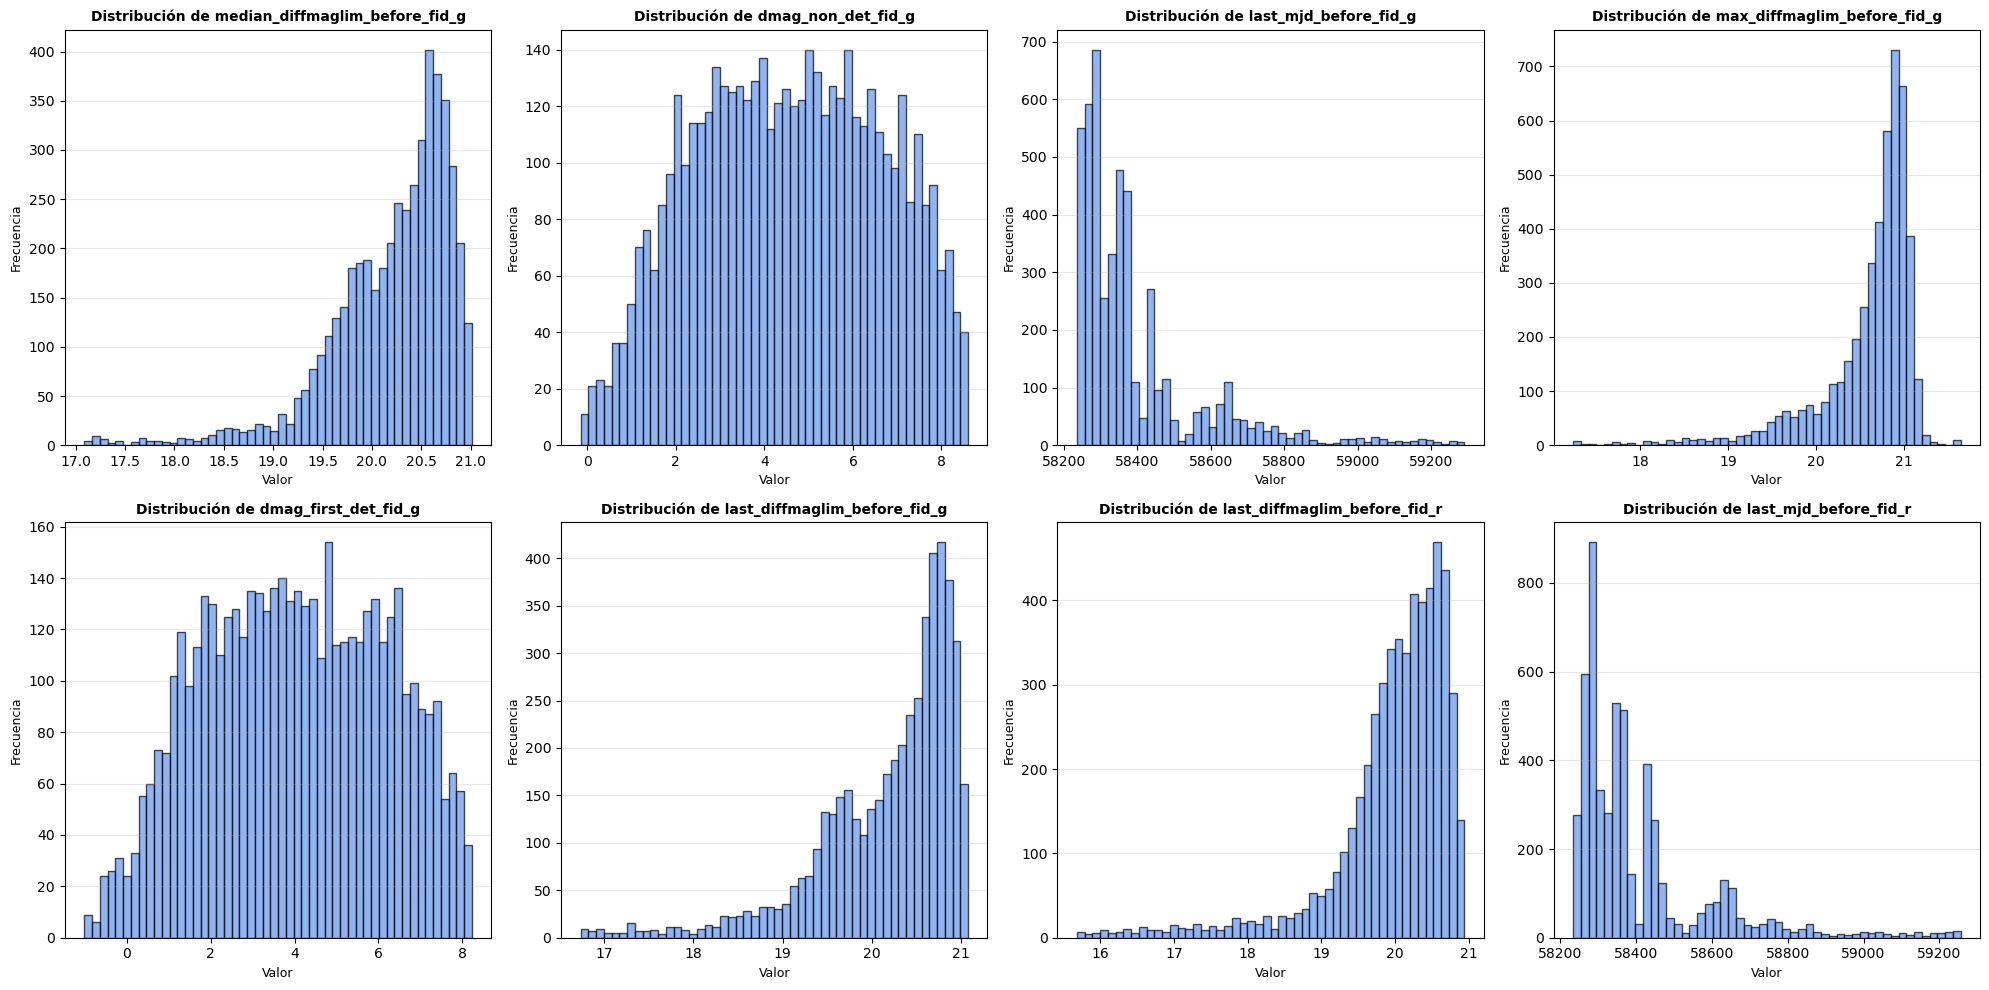

In [45]:
# Visualization of distributions for a sample of features with most nulls
null_counts = dataset[numeric_cols].isnull().sum().sort_values(ascending=False)
sample_features = null_counts.head(8).index.tolist() # Select 8 features with most nulls, can be adjusted

fig, axes = plt.subplots(2, 4, figsize=(20, 10)) # Adjusted to 2x4 for 8 features, can be changed
axes = axes.ravel()

for i, feature in enumerate(sample_features):
    if i < len(axes):
        # Remove extreme outliers for better visualization
        data = dataset[feature].dropna()
        if len(data) > 0:
            q1, q99 = data.quantile([0.01, 0.99])
            filtered_data = data[(data >= q1) & (data <= q99)]

            axes[i].hist(filtered_data, bins=50, alpha=0.7, color='cornflowerblue', edgecolor='black')
            axes[i].set_title(f'Distribución de {feature}', fontsize=10, fontweight='bold')
            axes[i].set_xlabel('Valor', fontsize=9)
            axes[i].set_ylabel('Frecuencia', fontsize=9)
            axes[i].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

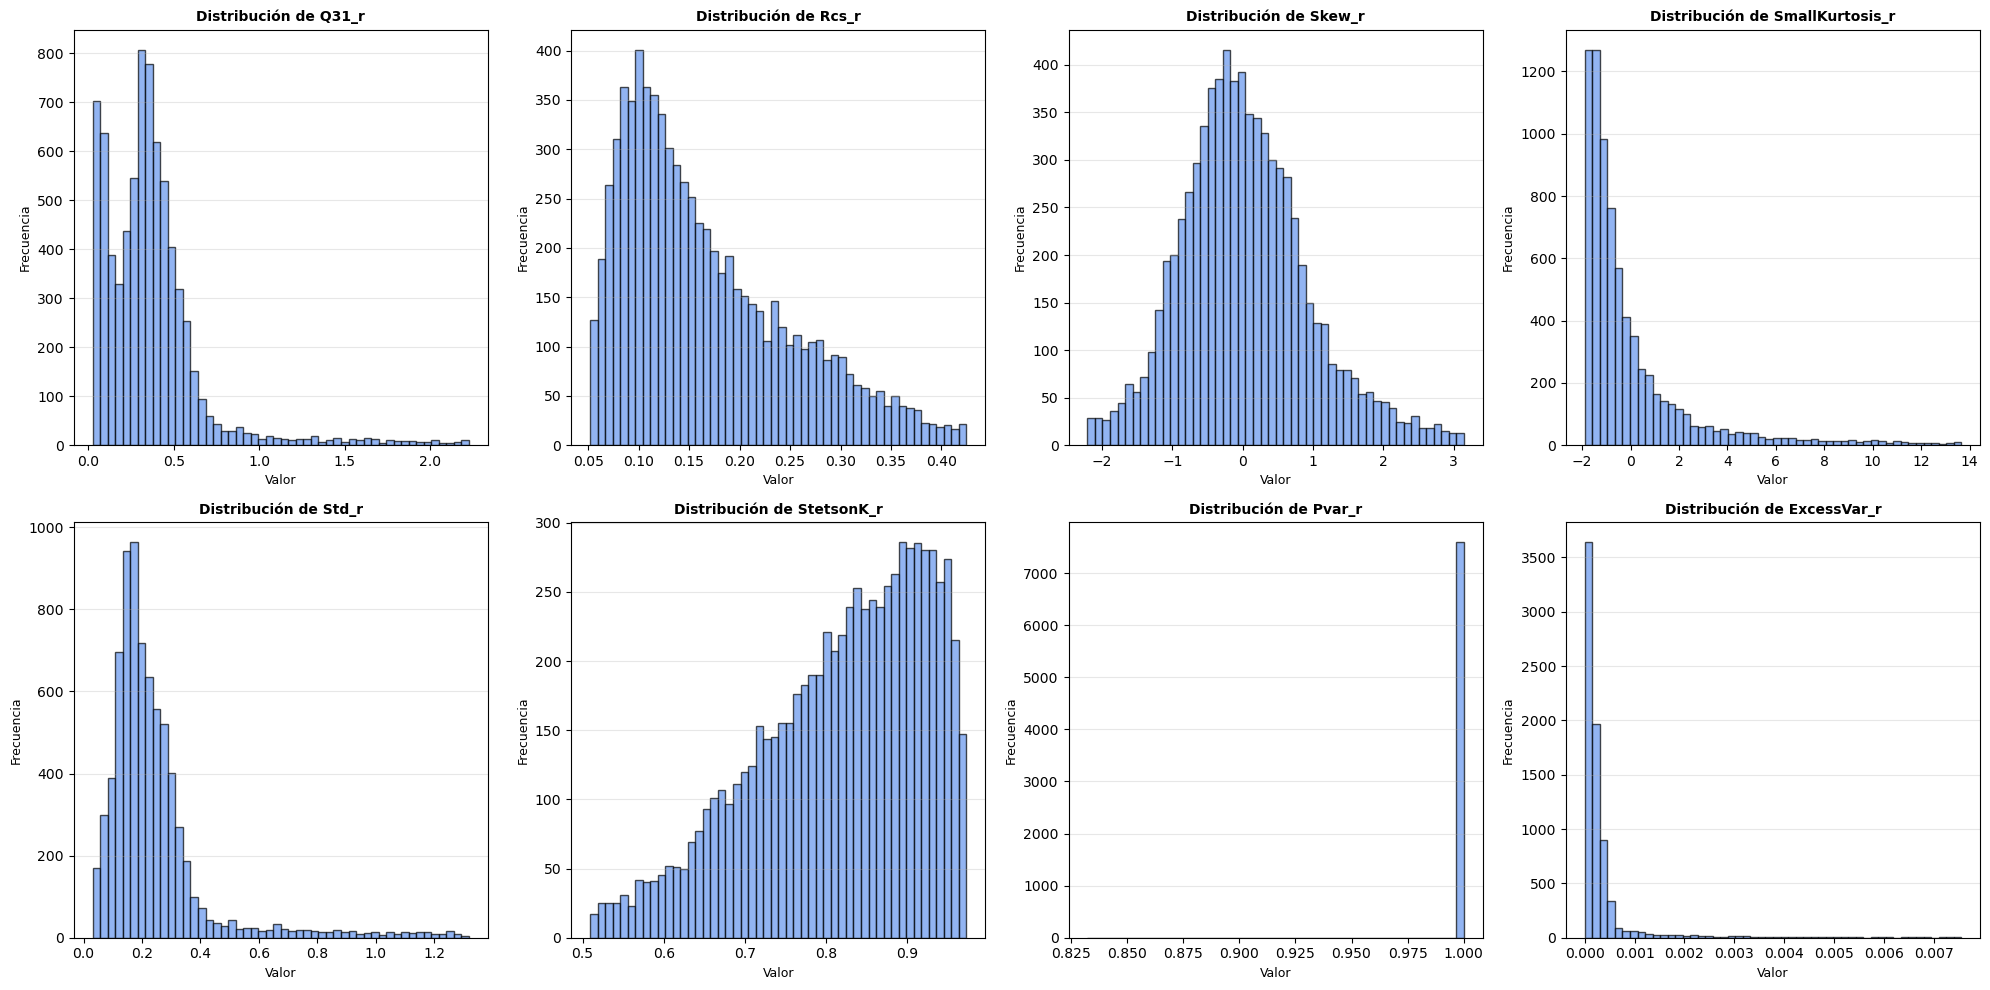

In [47]:
# Visualization of distributions for the first N numeric features
firstN_features = numeric_cols[:8] # Select first 8 features, can be adjusted

fig, axes = plt.subplots(2, 4, figsize=(20, 10)) # Adjusted to 2x4 for 8 features, can be changed
axes = axes.ravel()

for i, feature in enumerate(firstN_features):
    if i < len(axes):
        # Remove extreme outliers for better visualization
        data = dataset[feature].dropna()
        if len(data) > 0:
            q1, q99 = data.quantile([0.01, 0.99])
            filtered_data = data[(data >= q1) & (data <= q99)]

            axes[i].hist(filtered_data, bins=50, alpha=0.7, color='cornflowerblue', edgecolor='black')
            axes[i].set_title(f'Distribución de {feature}', fontsize=10, fontweight='bold')
            axes[i].set_xlabel('Valor', fontsize=9)
            axes[i].set_ylabel('Frecuencia', fontsize=9)
            axes[i].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Astronomical features analysis

In [51]:
# Identify important astronomical features
feature_cols = dataset.columns.tolist()
astro_patterns = ['period', 'freq', 'amplitude', 'phase', 'skew', 'kurt', 'beyond', 'slope', 'color', 'magnitude', 'harmonics', 'spm', 'mhps'] # This list can be adjusted

astro_features = []
for pattern in astro_patterns:
    matches = [col for col in feature_cols if pattern.lower() in col.lower()]
    astro_features.extend(matches)

astro_features = list(set(astro_features))
print(f"Features astronómicos identificados: {len(astro_features)}")
print(f"Ejemplos: {astro_features[:10]}")

Features astronómicos identificados: 75
Ejemplos: ['SPM_t0_g', 'SPM_gamma_g', 'Harmonics_mag_1_r', 'MHPS_ratio_r', 'Skew_r', 'MHPS_non_zero_g', 'Harmonics_phase_6_r', 'Harmonics_mag_2_g', 'MHPS_high_g', 'SPM_chi_g']


Features de período encontrados: ['delta_period_r', 'Multiband_period_g_r', 'Period_band_g', 'delta_period_g', 'Period_band_r']


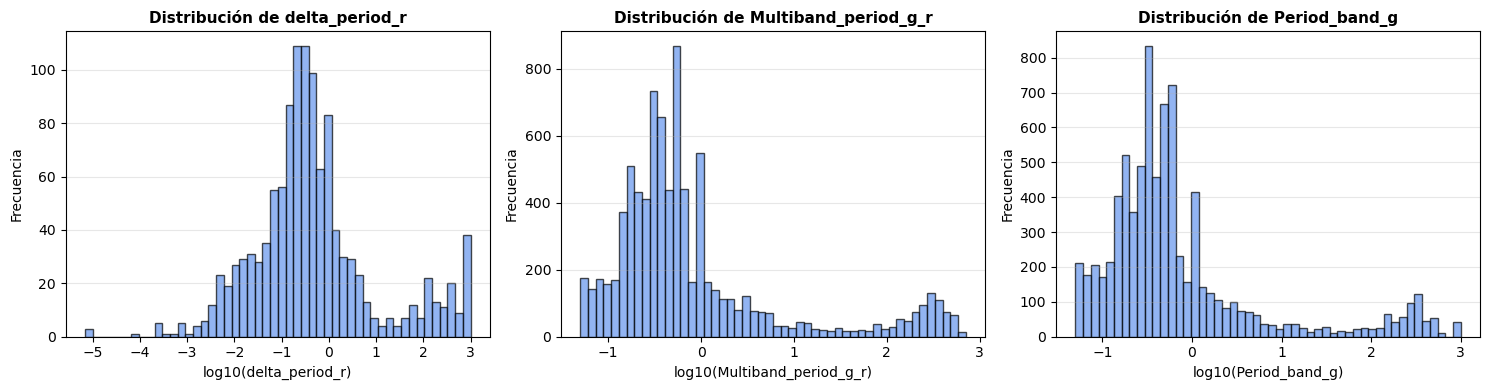

In [52]:
# Analysis of features related to 'period', the same code can be adapted for other patterns
period_features = [col for col in feature_cols if 'period' in col.lower()]
if period_features:
    print(f"Features de período encontrados: {period_features}")

    fig, axes = plt.subplots(1, min(3, len(period_features)), figsize=(15, 4))
    if len(period_features) == 1:
        axes = [axes]

    for i, feature in enumerate(period_features[:3]): # Limit to first 3 for visualization, can be adjusted
        data = dataset[feature].dropna()
        positive_data = data[data > 0]

        if len(positive_data) > 0:
            axes[i].hist(np.log10(positive_data), bins=50, alpha=0.7, color='cornflowerblue', edgecolor='black')
            axes[i].set_xlabel(f'log10({feature})', fontsize=10)
            axes[i].set_ylabel('Frecuencia', fontsize=10)
            axes[i].set_title(f'Distribución de {feature}', fontsize=11, fontweight='bold')
            axes[i].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

### Correlation matrix

In [56]:
# Analysis of correlations, using features with highest variance for clarity
variances = dataset[numeric_cols].var().sort_values(ascending=False)
top_features = variances.head(30).index.tolist() # Using top 30 features with highest variance, can be adjusted
corr_matrix = dataset[top_features].corr()

# Find high correlations
high_corr_pairs = []
correlations = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.8:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))
            correlations.append({
            'feature1': corr_matrix.columns[i],
            'feature2': corr_matrix.columns[j],
            'correlation': corr_val})

print(f"Pares de features con |correlación| > 0.8: {len(high_corr_pairs)}")

print("\n---")

print("\nTop 10 correlaciones más altas:")
sorted_pairs = sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)
for pair in sorted_pairs[:10]:
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")

Pares de features con |correlación| > 0.8: 31

---

Top 10 correlaciones más altas:
Harmonics_mag_6_r - Harmonics_mag_7_r: 1.000
Harmonics_mag_3_r - Harmonics_mag_5_r: 0.999
MHPS_non_zero_r - n_det_r: 0.999
Harmonics_mag_2_r - Harmonics_mag_3_r: 0.999
Harmonics_mag_5_r - Harmonics_mag_6_r: 0.999
Harmonics_mag_5_r - Harmonics_mag_7_r: 0.998
Harmonics_mag_3_r - Harmonics_mag_6_r: 0.998
Harmonics_mag_3_r - Harmonics_mag_7_r: 0.997
Harmonics_mag_2_r - Harmonics_mag_5_r: 0.996
Harmonics_mag_2_r - Harmonics_mag_6_r: 0.993


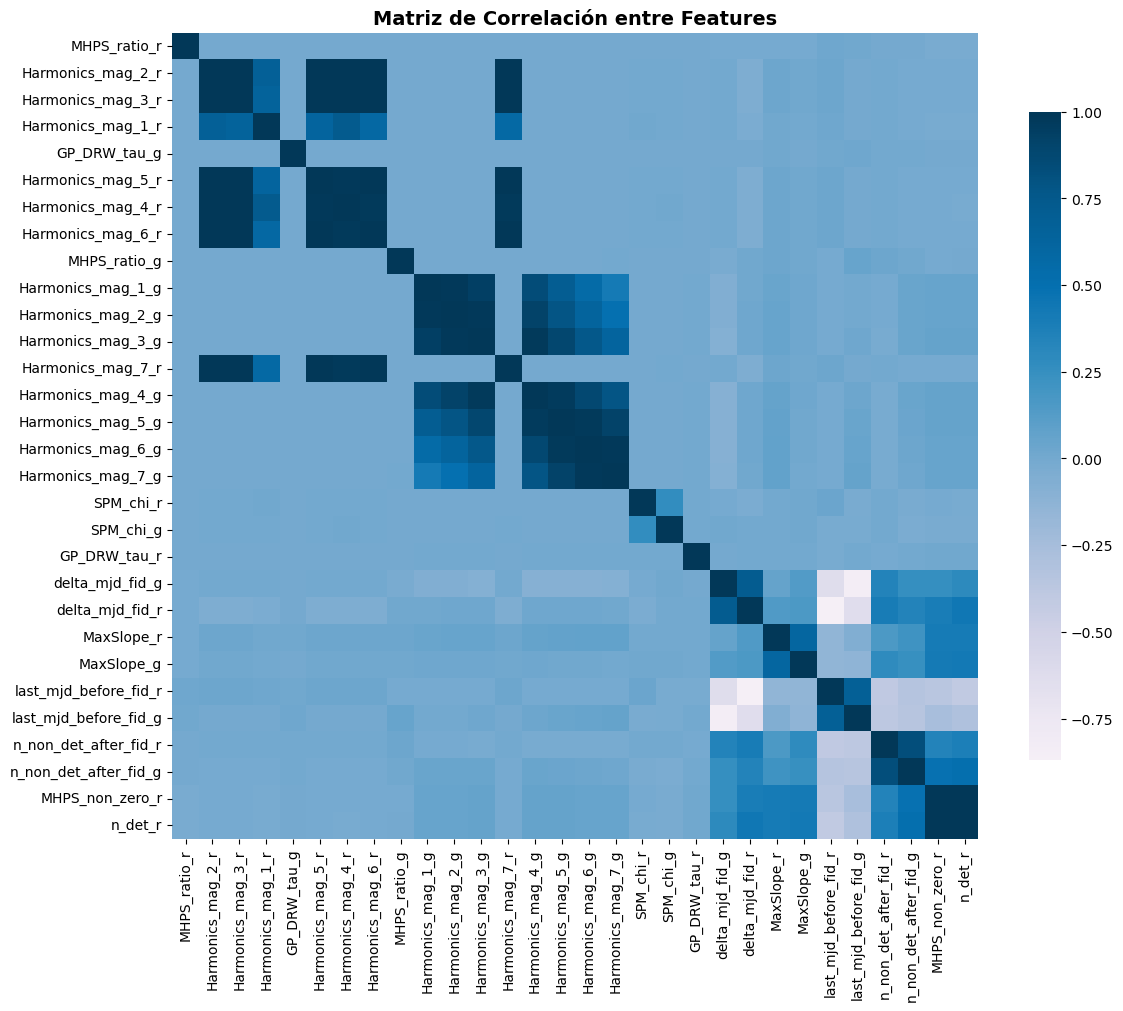

In [69]:
# Visualization of correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='PuBu', center=0, square=True, fmt='.2f', cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación entre Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

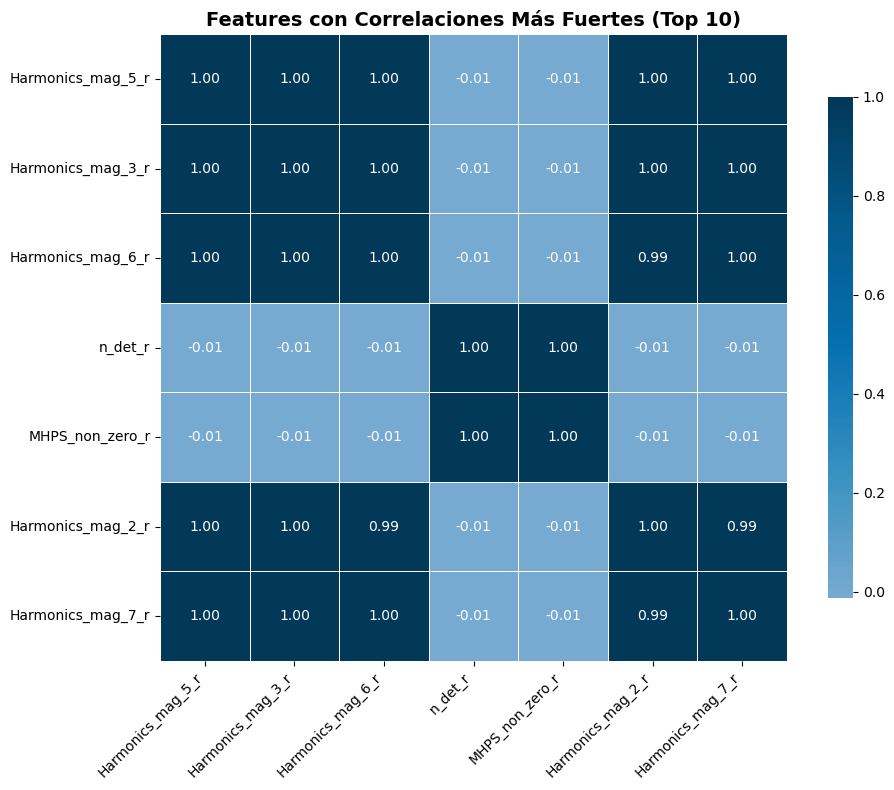

In [68]:
# Visualization of strongest correlations
corr_df = pd.DataFrame(correlations)
corr_df['abs_correlation'] = corr_df['correlation'].abs()
top_correlations = corr_df.nlargest(10, 'abs_correlation') # Top 10 correlations by absolute value, can be adjusted

involved_features = list(set(top_correlations['feature1'].tolist() + top_correlations['feature2'].tolist()))

mini_corr = corr_matrix.loc[involved_features, involved_features]

plt.figure(figsize=(10, 8))
sns.heatmap(mini_corr, annot=True, fmt='.2f', cmap='PuBu', center=0, square=True, cbar_kws={"shrink": 0.8}, linewidths=0.5)
plt.title('Features con Correlaciones Más Fuertes (Top 10)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

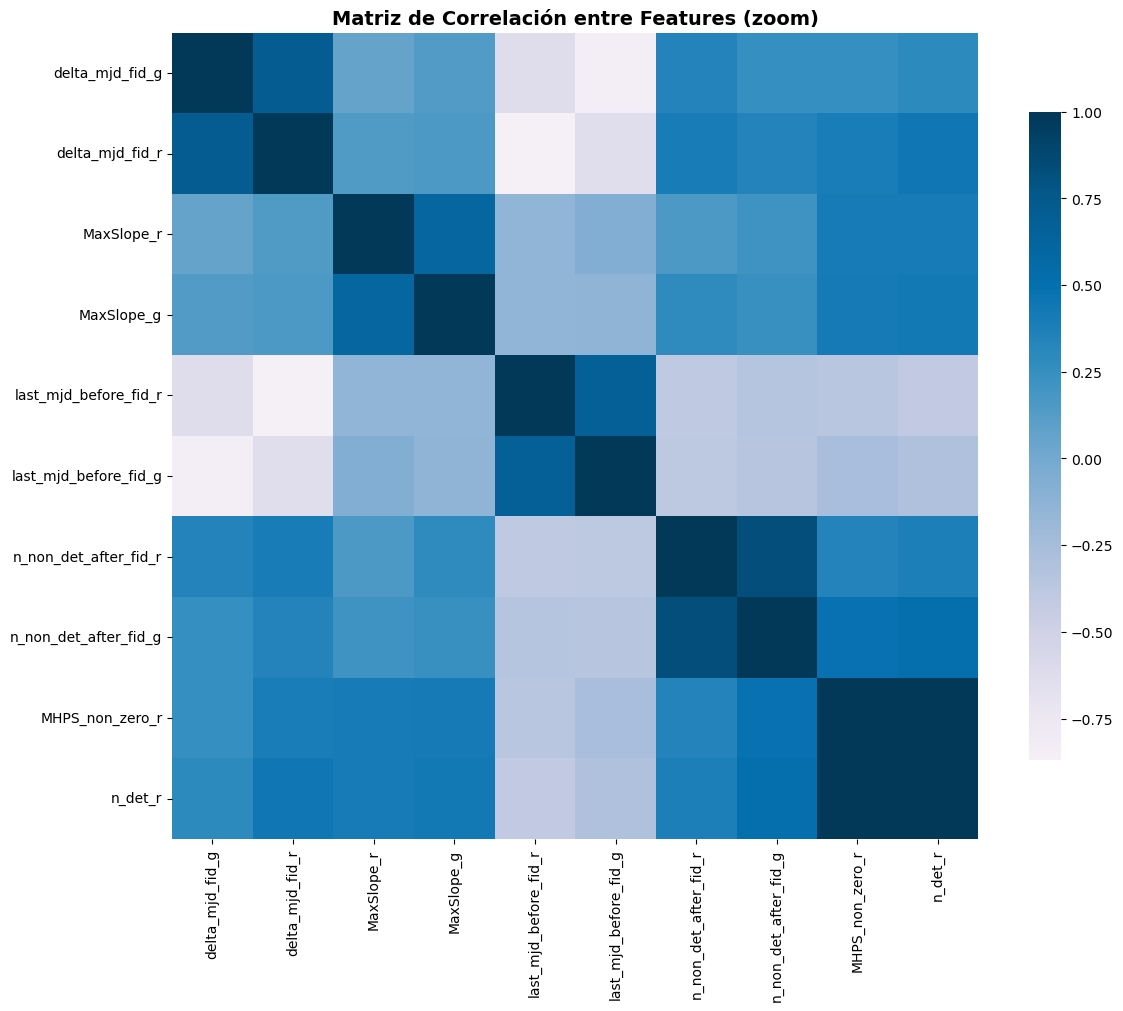

In [72]:
# Zoomed correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix.iloc[20:, 20:], annot=False, cmap='PuBu', center=0, square=True, fmt='.2f', cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación entre Features (zoom)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

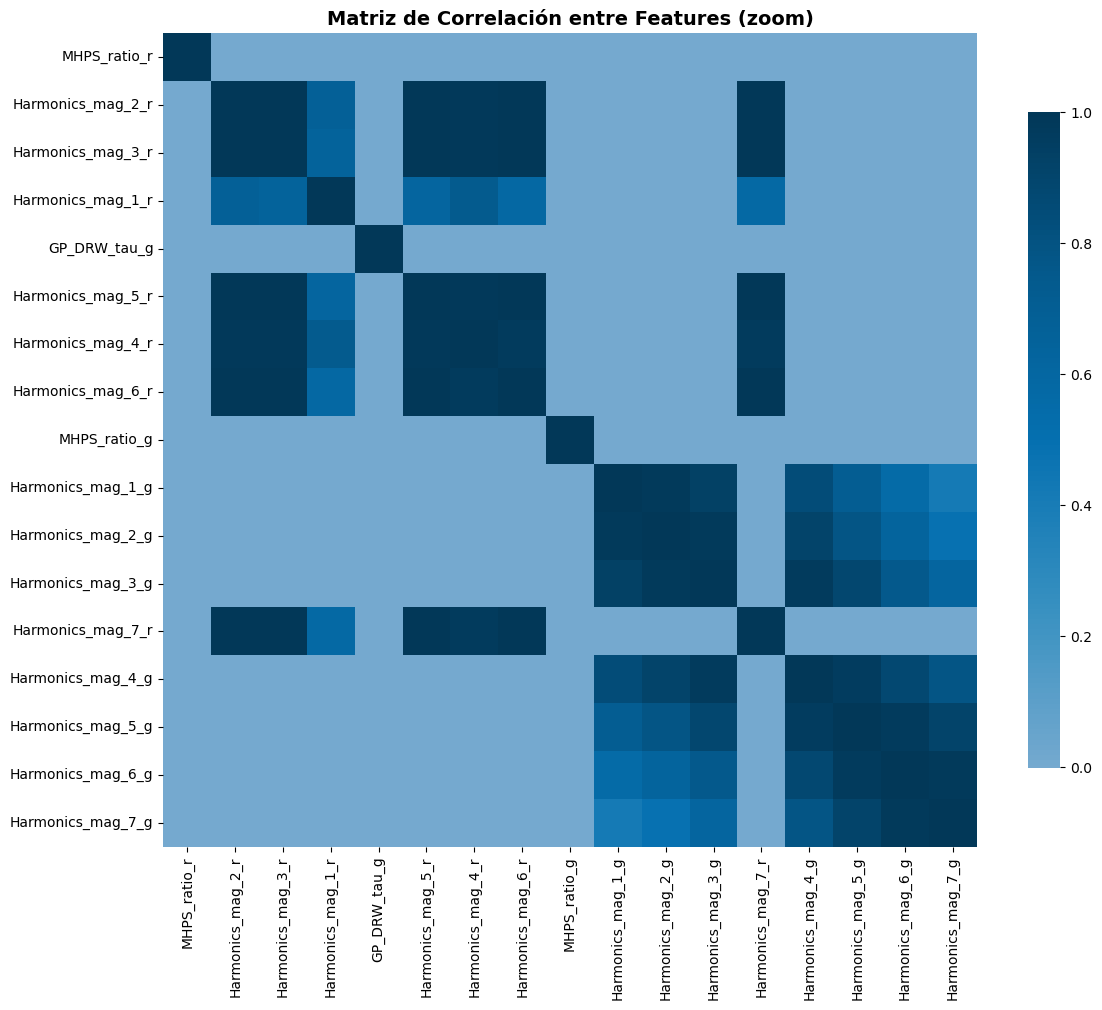

In [73]:
# Zoomed correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix.iloc[:17, :17], annot=False, cmap='PuBu', center=0, square=True, fmt='.2f', cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación entre Features (zoom)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Corner plot

Generate corner plot for: ['SPM_t0_g', 'SPM_gamma_g', 'Harmonics_mag_1_r', 'MHPS_ratio_r', 'Skew_r']


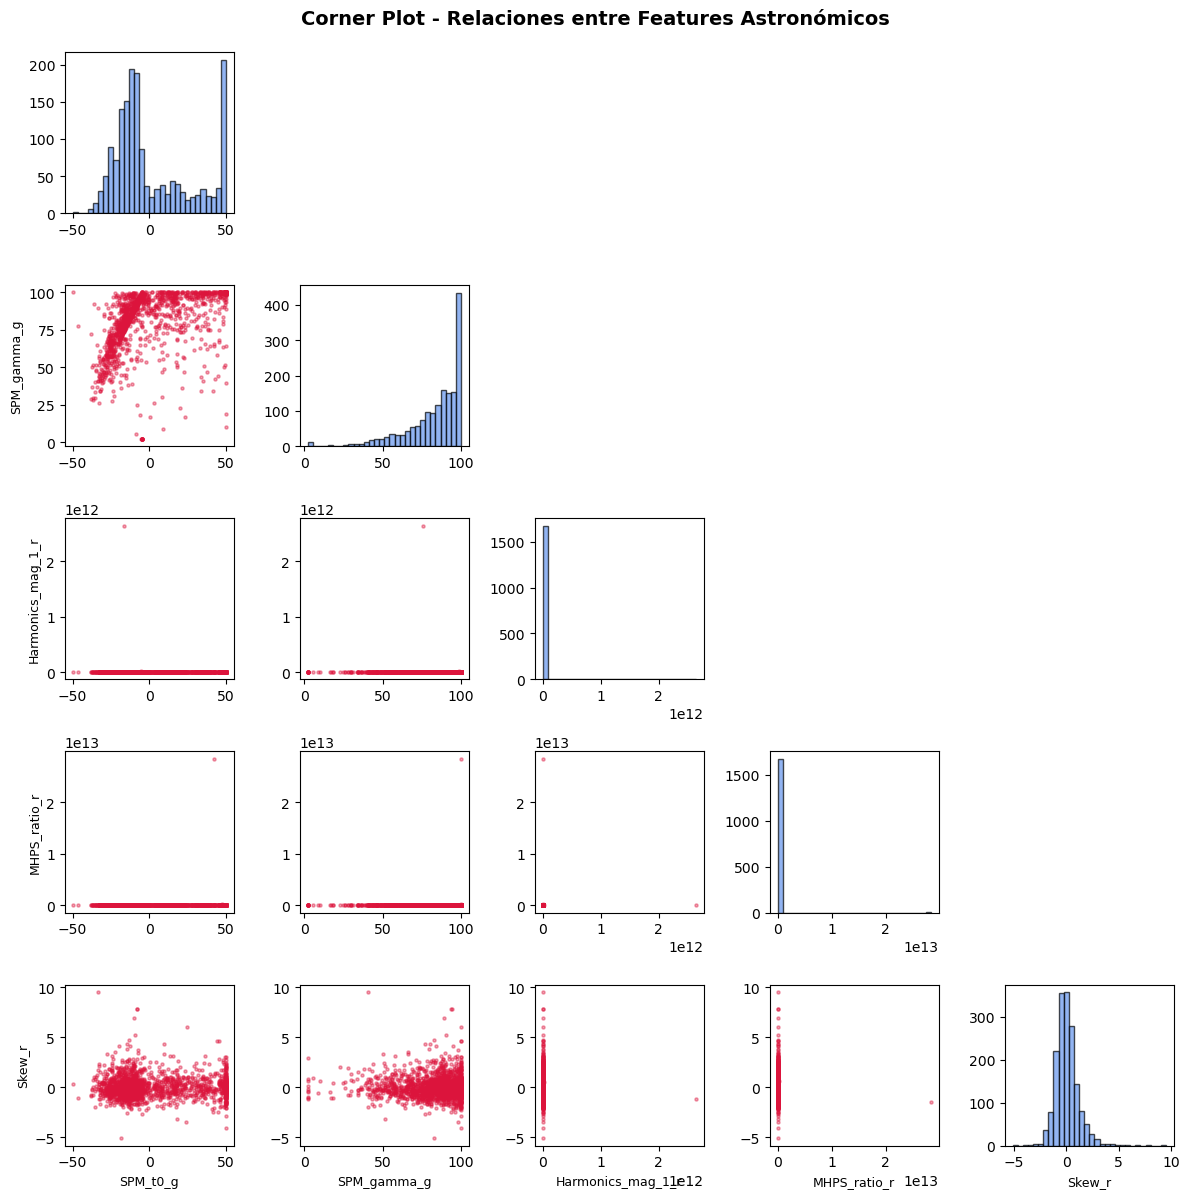

In [77]:
sample_features = astro_features[:5] # Select a few astronomical features for corner plot, can be adjusted
print(f"Generate corner plot for: {sample_features}")
sample_data = dataset.sample(n=2000, random_state=42)

plot_data = sample_data[sample_features].dropna()

fig, axes = plt.subplots(len(sample_features), len(sample_features), figsize=(12, 12))

for i, feat1 in enumerate(sample_features):
    for j, feat2 in enumerate(sample_features):
        ax = axes[i, j]

        if i == j: # Diagonal - histograms
            data = plot_data[feat1]
            ax.hist(data, bins=30, alpha=0.7, color='cornflowerblue', edgecolor='black')
            if i == len(sample_features) - 1:
                ax.set_xlabel(feat1, fontsize=9)

        elif i > j: # Inferior triangle - scatter plots
            x_data = plot_data[feat2]
            y_data = plot_data[feat1]
            ax.scatter(x_data, y_data, alpha=0.4, s=5, color='crimson')
            if j == 0:
                ax.set_ylabel(feat1, fontsize=9)
            if i == len(sample_features) - 1:
                ax.set_xlabel(feat2, fontsize=9)

        else: # Superior triangle - empty
            ax.axis('off')

plt.suptitle('Corner Plot - Relaciones entre Features Astronómicos', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

### PCA, UMAP and t-SNE

In [89]:
# Parameters for data preparation
max_features = 178
handle_missing = 'drop' # Options: 'drop', 'fill', 'median'

# Manejar valores faltantes
if handle_missing == 'drop':
    clean_data = dataset[numeric_cols].dropna()
    print(f"Lenght data after eliminate NaN: {len(clean_data)} objects")
    if 'alerceclass' in dataset.columns:
        labels = dataset.loc[clean_data.index, 'alerceclass'].values
elif handle_missing == 'fill':
    clean_data = dataset[numeric_cols].fillna(-99)
    print(f"NaN values filled with -99")
    labels = dataset['alerceclass'].values if 'alerceclass' in dataset.columns else None
else: # median
    clean_data = dataset[numeric_cols].fillna(dataset[numeric_cols].median())
    print(f"NaN values filled with median")
    labels = dataset['alerceclass'].values if 'alerceclass' in dataset.columns else None

# Select subset of features if there are too many, based on variance
if len(numeric_cols) > max_features:
    variances = clean_data.var().sort_values(ascending=False)
    selected_features = variances.head(max_features).index.tolist()
    clean_data = clean_data[selected_features]
    print(f"Selected {max_features} features with greater variance")
else:
    selected_features = numeric_cols

print("\n---")

print(f"\nFeatures finales seleccionadas: {len(selected_features)}")

print("\n---")

# Normalized data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(clean_data)
print(f"\nNormalized data: shape {normalized_data.shape}")

Lenght data after eliminate NaN: 2367 objects

---

Features finales seleccionadas: 178

---

Normalized data: shape (2367, 178)


Using PCA...
Using UMAP...


/home/vixo/miniforge3/envs/projectCI/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Using TSNE...


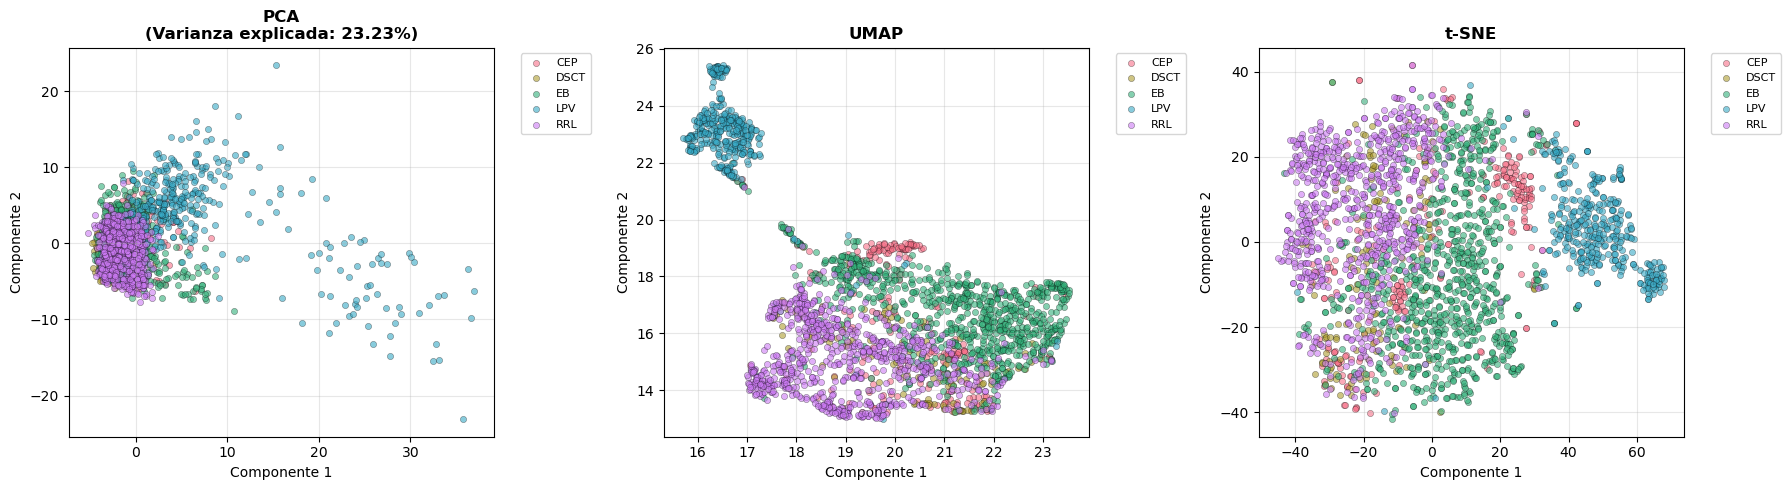

In [95]:
methods = ['PCA', 'UMAP', 'TSNE']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, method in enumerate(methods):
    print(f"Using {method}...")

    if method == 'PCA':
        reducer = PCA(n_components=2, random_state=42)
        embedding = reducer.fit_transform(normalized_data)
        explained_var = reducer.explained_variance_ratio_
        title = f'PCA\n(Varianza explicada: {explained_var.sum():.2%})'

    elif method == 'UMAP':
        reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
        embedding = reducer.fit_transform(normalized_data)
        title = 'UMAP'

    elif method == 'TSNE':
        # For t-SNE, use a sample if there are too many data points
        if len(normalized_data) > 5000:
            sample_idx = np.random.choice(len(normalized_data), 5000, replace=False)
            data_sample = normalized_data[sample_idx]
            labels_sample = labels[sample_idx] if labels is not None else None
        else:
            data_sample = normalized_data
            labels_sample = labels

        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
        embedding = reducer.fit_transform(data_sample)
        title = 't-SNE'

    # Plotting
    if labels is not None:
        plot_labels = labels_sample if method == 'TSNE' else labels
        unique_labels = np.unique(plot_labels)

        # USe just the top 10 classes for readability
        if len(unique_labels) > 10:
            top_classes = class_counts.head(10).index
            mask_top = np.isin(plot_labels, top_classes)
            embedding_plot = embedding[mask_top]
            labels_plot = plot_labels[mask_top]
        else:
            embedding_plot = embedding
            labels_plot = plot_labels

        unique_labels_plot = np.unique(labels_plot)
        #colors = plt.cm.Set3(np.linspace(0, 1, len(unique_labels_plot)))
        colors = sns.color_palette("husl", len(unique_labels_plot))

        for label, color in zip(unique_labels_plot, colors):
            mask = labels_plot == label
            axes[i].scatter(embedding_plot[mask, 0], embedding_plot[mask, 1], c=[color], label=label, alpha=0.6, s=20, edgecolors='black', linewidth=0.3)

        axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    else:
        axes[i].scatter(embedding[:, 0], embedding[:, 1], alpha=0.6, s=20, c='blue', edgecolors='black', linewidth=0.3)

    axes[i].set_title(title, fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Componente 1', fontsize=10)
    axes[i].set_ylabel('Componente 2', fontsize=10)
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()